<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

Крупной сети гипермаркетов необходимо внедрить систему компьютерного зрения для работы с фотографиями покупателей.

В прикассовой зоне будет происходить фотофиксация с целями:
* Контроль добросовестности продавцов при продаже алкоголя.  
* Более эффективное продвижение товаров для покупателей конкретной возрастной группы.

**Цель**  

Построить сверточную нейронную сеть, которая по фотографии определит приблизительный возраст человека. Значение метрики MAE не должно быть выше 7.

**Структура исследования**  

1. Исследовательский анализ данных
2. Обучение модели
3. Анализ обученной модели

**Использование дополнительных модулей**  

- `pandas` – редактор баз данных  
- `numpy` – работа с многомерными массивами  
- `matplotlib` – построение графиков  
- `keras` – работа с нейронными сетями  

## Исследовательский анализ данных

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   seed=12345)


features, target = next(train_gen_flow)

Found 7591 validated image filenames.


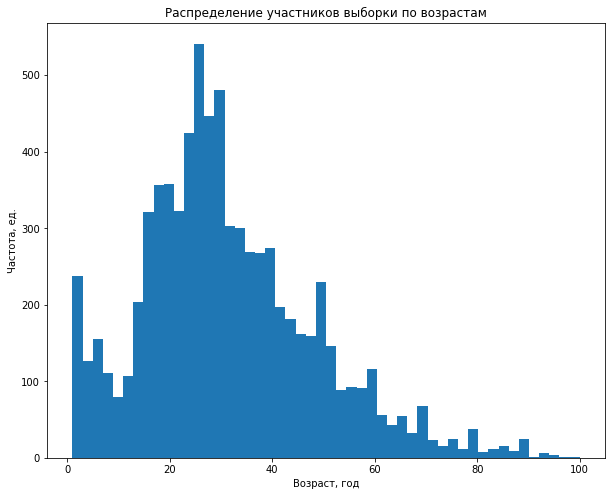

In [4]:
labels['real_age'].plot(kind='hist', bins=50, figsize=(10, 8))
plt.title('Распределение участников выборки по возрастам')
plt.xlabel('Возраст, год')
plt.ylabel('Частота, ед.')
plt.show()

Тип распределения напоминает бимодальное – характерные пики в возрасте от года и в районе 25-30 лет. После 40 лет количество людей в выборке начинает постепенно уменьшаться.

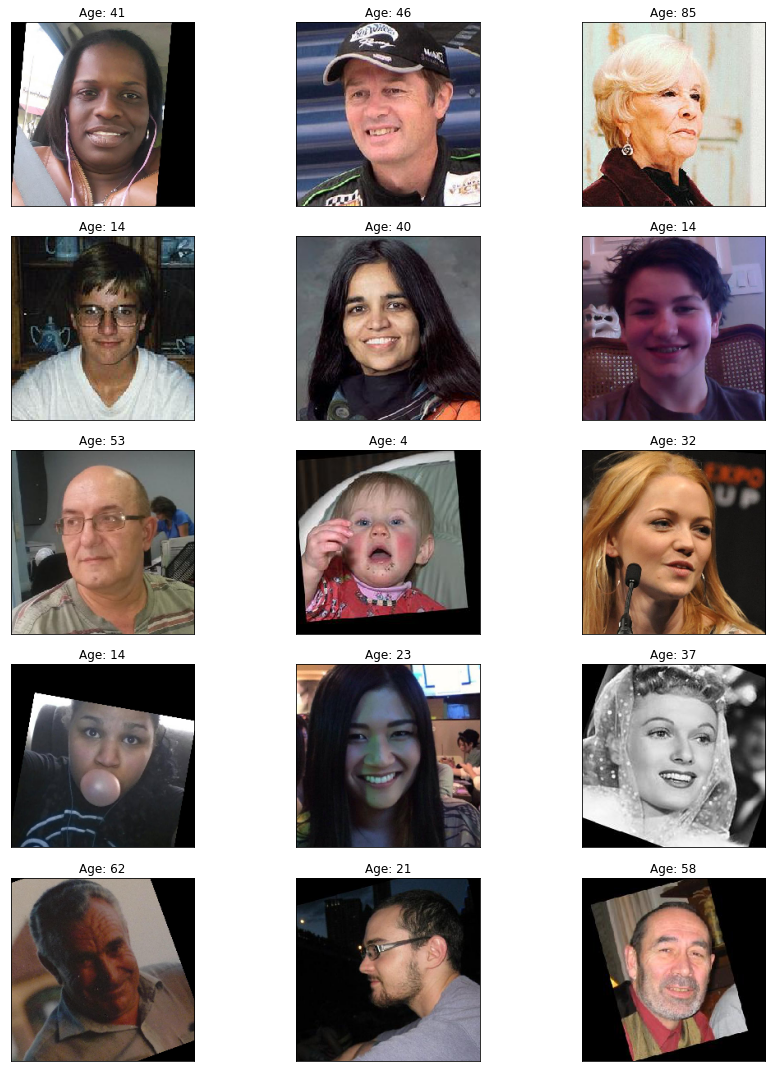

In [5]:
# Вывод реальных фотографий
fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 5

for i in range(1, 16):
    fig.add_subplot(rows, columns, i)
    plt.imshow(features[i])
    plt.title(f'Age: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Фотографии приемлемого качества с минимальным зашумлением.

## Обучение модели

```python

# Импорт необходимых библиотек
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    '''
    Функция для загрузки обучающей выборки
    Применена аугментация:
    - горизонтальное отражение (horizontal_flip)
    - поворот на малый угол (rotation_range)
    '''
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255,
                                       horizontal_flip=True,
		                               rotation_range=10)

    train_data = train_datagen.flow_from_dataframe(dataframe=labels,
		                                           directory=path + 'final_files/',
                                                   x_col='file_name',
		                                           y_col='real_age',
                                                   target_size=(224, 224),
		                                           batch_size=32,
                                                   class_mode='raw',
		                                           subset='training',
		                                           seed=12345)

    return train_data


def load_test(path):
    '''
    Функция для загрузки тестовой выборки
    '''
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255)

    test_data = test_datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path + 'final_files/',
                                                 x_col='file_name',
		                                         y_col='real_age',
                                                 target_size=(224, 224),
		                                         batch_size=32,
                                                 class_mode='raw',
		                                         subset='validation',
		                                         seed=12345)

    return test_data


def create_model(input_shape):
    '''
    Функция для создания модели:
    - используется архитектура ResNet50 в сочетании с GlobalAveragePooling2D
    - выходной слой с 1 нейроном и функцией активации ReLu
    - функция потерь MSE
    - метрика качеста MAE
    '''
    optimizer = Adam(lr=0.0001)
	
    model = Sequential()

    beckbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model.add(beckbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer,
                  loss='mse',
				  metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    '''
    Функция для обучения модели (на 10-ти эпохах)
    '''

    if steps_per_epoch is None:
	    steps_per_epoch = len(train_data)
    if validation_steps is None:
	    validation_steps = len(test_data)
	
	
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps, 
              verbose=2,
			  shuffle=True)
    
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 94s - loss: 229.4148 - mae: 10.8907 - val_loss: 612.0980 - val_mae: 19.7504
Epoch 2/10
178/178 - 88s - loss: 81.3963 - mae: 6.8126 - val_loss: 788.8343 - val_mae: 23.1375
Epoch 3/10
178/178 - 88s - loss: 60.2955 - mae: 5.8994 - val_loss: 304.4205 - val_mae: 12.8575
Epoch 4/10
178/178 - 89s - loss: 43.0648 - mae: 5.0344 - val_loss: 118.5373 - val_mae: 8.2635
Epoch 5/10
178/178 - 88s - loss: 36.5378 - mae: 4.6154 - val_loss: 89.9228 - val_mae: 7.3526
Epoch 6/10
178/178 - 88s - loss: 29.8878 - mae: 4.2440 - val_loss: 100.4275 - val_mae: 7.4984
Epoch 7/10
178/178 - 88s - loss: 27.2069 - mae: 4.0310 - val_loss: 75.0440 - val_mae: 6.3506
Epoch 8/10
178/178 - 88s - loss: 22.0566 - mae: 3.6414 - val_loss: 75.5035 - val_mae: 6.5333
Epoch 9/10
178/178 - 88s - loss: 19.0299 - mae: 3.3334 - val_loss: 77.9558 - val_mae: 6.7116
Epoch 10/10
178/178 - 88s - loss: 17.4291 - mae: 3.2048 - val_loss: 70.7233 - val_mae: 6.1646

60/60 - 9s - loss: 70.7233 - mae: 6.1646
Test MAE: 6.1646

```

## Анализ обученной модели

Результат обучения модели (на 10-и эпохах):

* МАЕ на обучающей выборке: 3.20;  
* МАЕ на тестовой выборке: 6.16.  

Модель достигла метрики требуемого значения MAE, т.е. менее 7.

Формально небольшая ошибка позволяет модели справляться с поставленными задачами. Тем не менее, долю выборки участников в возрасте от 8 (возможность самостоятельно покупки в магазине) до 18 (возраст продажи алкоголя) лет стоило бы увеличить, с целью ещё большей минимизации полученной ошибки.